In [1]:
# %% [markdown]
# # 1) Thư viện & Cấu hình
# - NumPy: tính toán vector.
# - Matplotlib/Seaborn: trực quan hóa kết quả.
# - Tiện ích: set_seed, timer, plot_convergence.

# %%
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time, os
import math
import matplotlib as mpl
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

mpl.rcParams["font.family"] = "DejaVu Sans"

try:
    import seaborn as sns
    sns.set(style="whitegrid")
except Exception:
    pass

os.makedirs("results", exist_ok=True)

# Đặt seed cố định để tái lập kết quả
def set_seed(seed=42):
    np.random.seed(seed)

# Bộ đếm thời gian thực thi
def timer(func):
    def wrapper(*args, **kwargs):
        t0 = time.time()
        out = func(*args, **kwargs)
        print(f"⏱ {func.__name__} chạy {time.time()-t0:.3f}s")
        return out
    return wrapper

# Vẽ biểu đồ hội tụ
def plot_convergence(histories, labels, title="Biểu đồ hội tụ"):
    plt.figure(figsize=(8,5))
    for h, lbl in zip(histories, labels):
        plt.plot(h, label=lbl, linewidth=1.6)
    plt.xlabel("Vòng lặp")
    plt.ylabel("Giá trị tốt nhất f(x)")
    plt.title(title)
    plt.legend()
    plt.grid(True, alpha=0.4)
    plt.tight_layout()
    plt.show()

# Giới hạn biến trong [lb, ub]
def clamp(x, lb, ub):
    return np.minimum(np.maximum(x, lb), ub)


In [2]:
# %% [markdown]
# # Firefly Algorithm – Version 3 (Continuous + Binary)
# 
# Các cải tiến chính:
# - Thêm Lévy flight (Mantegna) để nhảy xa, giúp thoát local minima (đặc biệt với Rastrigin)
# - Giảm chi phí tính toán bằng stochastic pairing (chỉ chọn ngẫu nhiên 30% cặp i,j)
# - Thêm “hybrid global-guided term” (hút nhẹ về global best)
# - Cơ chế adaptive decay 2 pha: khi không cải thiện, giảm alpha_min & tăng decay
# - Reinit thông minh khi stagnation quá lâu (tái tạo 10% cá thể)
# - Binarization theo nhiệt độ (τ), logistic-tanh sigmoid giúp bit chuyển mượt hơn
# - Adaptive mutation & local 1-bit flip giúp FA-binary tránh “pattern lock”
# 
# → Áp dụng cho cả Continuous và Discrete (Knapsack)
# ---------------------------------------------------------------

# --------------------------
# Utility: Lévy step (Mantegna)
# --------------------------
def levy_step(rng, dim, beta=1.5, scale=0.01):
    """
    Sinh ra bước nhảy Lévy theo Mantegna’s algorithm.
    Lévy flight giúp đom đóm 'nhảy xa' – tăng khả năng khám phá global minima.
    """
    sigma_u = (math.gamma(1+beta) * math.sin(np.pi*beta/2) /
               (math.gamma((1+beta)/2) * beta * 2**((beta-1)/2))) ** (1/beta)
    u = rng.normal(0, sigma_u, dim)
    v = rng.normal(0, 1, dim)
    step = u / (np.abs(v) ** (1/beta))
    return scale * step


# --------------------------
# Main Class
# --------------------------
class Firefly:
    def __init__(self, func, dim, mode='continuous',
                 n=40, iters=500,
                 alpha=0.2, beta0=1.0, gamma=0.5, decay=0.98,
                 lb=-5, ub=5, alpha_min=0.03,
                 repair=None, seed=None,
                 gb=0.1, k_neighbors=10, verbose=False):
        """
        Firefly Algorithm tổng quát – hỗ trợ Continuous & Binary (0/1)

        Parameters
        ----------
        func : callable
            Hàm mục tiêu (minimize).
        dim : int
            Số chiều (biến).
        mode : {'continuous', 'binary'}
            Loại bài toán.
        n : int
            Số lượng đom đóm.
        iters : int
            Số vòng lặp tối đa.
        alpha : float
            Cường độ ngẫu nhiên ban đầu.
        beta0 : float
            Hệ số hấp dẫn cơ sở.
        gamma : float
            Hệ số suy giảm hấp dẫn (với khoảng cách).
        decay : float
            Tốc độ giảm alpha sau mỗi vòng.
        lb, ub : float
            Biên dưới/trên cho biến (continuous).
        repair : callable
            Hàm sửa nghiệm (với binary Knapsack).
        gb : float
            Tỷ lệ hút nhẹ về global best.
        k_neighbors : int
            Số cá thể được chọn khi dùng tournament.
        verbose : bool
            In log tiến trình.
        """
        self.func = func
        self.dim = dim
        self.mode = mode
        self.n = n
        self.iters = iters
        self.alpha = alpha
        self.alpha_min = alpha_min
        self.beta0 = beta0
        self.gamma = gamma
        self.decay = decay
        self.lb, self.ub = lb, ub
        self.repair = repair
        self.seed = seed
        self.gb = gb
        self.k_neighbors = k_neighbors
        self.verbose = verbose
        self.rng = np.random.default_rng(seed)
        self.history = []

    # --------------------------
    # Helper functions
    # --------------------------
    def _init_population(self):
        """Khởi tạo quần thể ban đầu."""
        if self.mode == 'continuous':
            X = self.rng.uniform(self.lb, self.ub, (self.n, self.dim))
        else:
            X = self.rng.integers(0, 2, (self.n, self.dim))
        F = np.apply_along_axis(self.func, 1, X)
        return X, F

    def _distance(self, xi, xj):
        """Khoảng cách giữa 2 cá thể (Euclidean)."""
        return np.linalg.norm(xi - xj)

    def _move_pair(self, xi, xj, best_x):
        """
        Di chuyển xi về phía xj (đom đóm sáng hơn).
        Có thêm thành phần global-guided (gb) hút nhẹ về best_x.
        """
        r = self._distance(xi, xj)
        beta = self.beta0 * np.exp(-self.gamma * r**2)
        step = beta * (xj - xi) + self.gb * (best_x - xi)
        xi_new = xi + step + self.alpha * (self.rng.random(self.dim) - 0.5)
        return np.clip(xi_new, self.lb, self.ub)

    # --------------------------
    # Optimize Continuous Mode
    # --------------------------
    def _optimize_continuous(self):
        X, F = self._init_population()
        best_idx = np.argmin(F)
        best_x, best_f = X[best_idx].copy(), F[best_idx]
        alpha0 = self.alpha
        no_improve = 0

        for t in range(self.iters):
            pairs = self.rng.integers(0, self.n, (int(self.n * 0.3), 2))
            for i, j in pairs:
                if F[j] < F[i]:
                    X[i] = self._move_pair(X[i], X[j], best_x)

                    # Lévy flight cho 10% cá thể – nhảy xa
                    if self.rng.random() < 0.1:
                        scale = 0.03 if t < self.iters // 2 else 0.01
                        X[i] += levy_step(self.rng, self.dim, beta=1.5, scale=scale * (self.ub - self.lb))
                    X[i] = np.clip(X[i], self.lb, self.ub)
                    F[i] = self.func(X[i])

            # cập nhật best
            min_idx = np.argmin(F)
            if F[min_idx] < best_f - 1e-12:
                best_x, best_f = X[min_idx].copy(), F[min_idx]
                no_improve = 0
            else:
                no_improve += 1

            # adaptive decay & alpha update
            self.alpha = max(self.alpha_min, self.alpha * self.decay)
            if no_improve == 50:
                self.decay = max(self.decay, 0.995)
                self.alpha_min = min(self.alpha_min, 0.02)
            if no_improve > 120:
                # tái khởi tạo 10% cá thể + reset alpha
                m = max(1, int(0.1 * self.n))
                idx = self.rng.choice(self.n, size=m, replace=False)
                X[idx] = self.rng.uniform(self.lb, self.ub, (m, self.dim))
                F[idx] = np.apply_along_axis(self.func, 1, X[idx])
                self.alpha = alpha0
                no_improve = 0

            self.history.append(best_f)
            if self.verbose and (t % 100 == 0):
                print(f"Iter {t}: best_f={best_f:.4e}")

        return best_x, best_f

    # --------------------------
    # Optimize Binary Mode
    # --------------------------
    def _optimize_binary(self):
        X, F = self._init_population()
        best_idx = np.argmin(F)
        best_x, best_f = X[best_idx].copy(), F[best_idx]
        no_improve = 0

        for t in range(self.iters):
            pairs = self.rng.integers(0, self.n, (int(self.n * 0.3), 2))
            for i, j in pairs:
                if F[j] < F[i]:
                    z = X[j] - X[i]
                    # Binarization có nhiệt độ (τ giảm dần)
                    tau = max(0.3, 1.5 * (self.decay ** t))
                    p = 0.5 * (1 + np.tanh(z / tau))
                    x_new = (p > self.rng.random(self.dim)).astype(np.int8)

                    # Local hill-climb 1–2 bit flip
                    x_new = self._local_flip(x_new, X[i], F[i])

                    # Adaptive mutation nếu stagnation lâu
                    pm = min(0.05, 0.01 + 0.001 * no_improve)
                    if self.rng.random() < pm:
                        flip_mask = (self.rng.random(self.dim) < 0.02)
                        x_new[flip_mask] ^= 1

                    # Repair đảm bảo nghiệm hợp lệ
                    if self.repair is not None:
                        x_new = self.repair(x_new)

                    f_new = self.func(x_new)
                    if f_new < F[i]:
                        X[i], F[i] = x_new, f_new

            min_idx = np.argmin(F)
            if F[min_idx] < best_f - 1e-12:
                best_x, best_f = X[min_idx].copy(), F[min_idx]
                no_improve = 0
            else:
                no_improve += 1

            self.history.append(best_f)
            if self.verbose and (t % 100 == 0):
                print(f"Iter {t}: best_f={best_f:.3f}")

        return best_x, best_f

    def _local_flip(self, x_new, x_old, f_old):
        """Thử lật 1–2 bit ngẫu nhiên, nếu cải thiện thì nhận."""
        x2 = x_new.copy()
        k = int(self.rng.integers(0, self.dim))
        x2[k] ^= 1
        if self.repair: x2 = self.repair(x2)
        f2 = self.func(x2)
        if f2 < f_old: return x2

        # thử 2-bit
        k2 = int(self.rng.integers(0, self.dim))
        if k2 != k:
            x3 = x_new.copy()
            x3[k] ^= 1; x3[k2] ^= 1
            if self.repair: x3 = self.repair(x3)
            f3 = self.func(x3)
            if f3 < f_old: return x3
        return x_new

    # --------------------------
    # Wrapper optimize()
    # --------------------------
    def optimize(self):
        """
        Wrapper chọn hàm tối ưu phù hợp với mode (continuous / binary)
        """
        if self.mode == 'continuous':
            return self._optimize_continuous()
        else:
            return self._optimize_binary()


In [3]:
# %% [markdown]
# ## 3.1 Hill Climbing (HC)
# - Ý tưởng: duyệt lân cận ngẫu nhiên; nếu tốt hơn thì nhận.
# - Continuous: perturb Gaussian nhỏ (theo tỷ lệ miền).
# - Binary: lật ngẫu nhiên k bit (mặc định k=1).
# - Không có "nhiệt độ" → dễ kẹt local; dùng để làm baseline.
# %%
class HillClimb:
    def __init__(self, func, dim, mode='continuous', iters=1000,
                 step=0.1, lb=-5, ub=5, seed=None, repair=None):
        self.func,self.dim,self.mode=func,dim,mode
        self.iters,self.step,self.lb,self.ub=iters,step,lb,ub
        self.repair=repair; self.rng=np.random.default_rng(seed)
        self.history=[]

    def _init_x(self):
        if self.mode=='continuous': return self.rng.uniform(self.lb,self.ub,self.dim)
        else: return self.rng.integers(0,2,self.dim,dtype=np.int8)

    def _neighbor(self,x):
        if self.mode=='continuous':
            step=(np.array(self.ub)-np.array(self.lb))*self.step
            x_new=x+(self.rng.random(self.dim)-0.5)*step
            return clamp(x_new,self.lb,self.ub)
        else:
            x_new=x.copy(); k=int(self.rng.integers(1,min(3,self.dim)+1))
            idx=self.rng.choice(self.dim,size=k,replace=False)
            x_new[idx]^=1
            if self.repair is not None: x_new=self.repair(x_new)
            return x_new

    @timer
    def optimize(self):
        x=self._init_x(); f=self.func(x)
        for _ in range(self.iters):
            xn=self._neighbor(x); fn=self.func(xn)
            if fn<f: x,f=xn,fn
            self.history.append(f)
        return x,f



In [4]:
# %% [markdown]
# ## 3.2 Simulated Annealing (SA)
# - Có "nhiệt độ" T: chấp nhận lời giải xấu hơn với xác suất exp(-(Δ)/T)
# - T giảm dần theo lịch (cooling).
# - Giúp thoát local minima tốt hơn HC.

class SimulatedAnnealing:
    def __init__(self, func, dim, mode='continuous', iters=1000,
                 T0=1.5, cooling=0.995, lb=-5, ub=5, seed=None, repair=None):
        self.func,self.dim,self.mode=func,dim,mode
        self.iters,self.T0,self.cooling=iters,T0,cooling
        self.lb,self.ub,self.repair=lb,ub,repair
        self.rng=np.random.default_rng(seed); self.history=[]

    def _init_x(self):
        if self.mode=='continuous': return self.rng.uniform(self.lb,self.ub,self.dim)
        else: return self.rng.integers(0,2,self.dim,dtype=np.int8)

    def _neighbor(self,x):
        if self.mode=='continuous':
            step=(np.array(self.ub)-np.array(self.lb))*0.1
            x_new=x+(self.rng.random(self.dim)-0.5)*step
            return clamp(x_new,self.lb,self.ub)
        else:
            x_new=x.copy(); k=int(self.rng.integers(1,min(3,self.dim)+1))
            idx=self.rng.choice(self.dim,size=k,replace=False)
            x_new[idx]^=1
            if self.repair is not None:x_new=self.repair(x_new)
            return x_new

    @timer
    def optimize(self):
        x=self._init_x(); f=self.func(x); T=self.T0
        for _ in range(self.iters):
            xn=self._neighbor(x); fn=self.func(xn)
            if fn<f or np.exp((f-fn)/max(1e-12,T))>self.rng.random():
                x,f=xn,fn
            self.history.append(f); T*=self.cooling
        return x,f
    


In [5]:
# %% [markdown]
# ## 3.3 Genetic Algorithm (GA)
# - Quần thể, chọn lọc, lai, đột biến.
# - Continuous: dùng 1-point crossover đơn giản + Gaussian-like mutation (NumPy-only).
# - Binary: 1-point crossover + bit-flip mutation.
# - Tournament selection (k=2) để chọn bố mẹ.

# %%
class GeneticAlgorithm:
    def __init__(self, func, dim, mode='continuous', pop=60, iters=500,
                 pc=0.9, pm=0.03, lb=-5, ub=5, seed=None, repair=None):
        self.func,self.dim,self.mode=func,dim,mode
        self.pop,self.iters,self.pc,self.pm=pop,iters,pc,pm
        self.lb,self.ub,self.repair=lb,ub,repair
        self.rng=np.random.default_rng(seed); self.history=[]

    def _init_pop(self):
        if self.mode=='continuous':
            X=self.rng.uniform(self.lb,self.ub,(self.pop,self.dim))
        else:
            X=self.rng.integers(0,2,(self.pop,self.dim),dtype=np.int8)
            if self.repair is not None:
                X=np.array([self.repair(x) for x in X],dtype=np.int8)
        F=np.apply_along_axis(self.func,1,X)
        return X,F

    def _tournament(self,F,k=3):
        cand=self.rng.integers(0,len(F),size=k)
        return cand[np.argmin(F[cand])]

    def _crossover(self,p1,p2):
        c=int(self.rng.integers(1,self.dim))
        c1,c2=p1.copy(),p2.copy()
        c1[c:],c2[c:]=p2[c:],p1[c:]
        return c1,c2

    def _mutate(self,x):
        if self.mode=='continuous':
            step=(np.array(self.ub)-np.array(self.lb))*0.05
            mask=self.rng.random(self.dim)<self.pm
            x=x+mask*(self.rng.random(self.dim)-0.5)*step
            return clamp(x,self.lb,self.ub)
        else:
            mask=self.rng.random(self.dim)<self.pm; x=x.copy(); x[mask]^=1
            if self.repair is not None:x=self.repair(x)
            return x

    @timer
    def optimize(self):
        X,F=self._init_pop()
        for _ in range(self.iters):
            new=[]
            elite=X[F.argmin()].copy(); new.append(elite)
            while len(new)<self.pop:
                i=self._tournament(F); j=self._tournament(F)
                p1,p2=X[i],X[j]
                if self.rng.random()<self.pc:c1,c2=self._crossover(p1,p2)
                else:c1,c2=p1.copy(),p2.copy()
                c1=self._mutate(c1); new.append(c1)
                if len(new)<self.pop:
                    c2=self._mutate(c2); new.append(c2)
            X=np.array(new[:self.pop],dtype=X.dtype)
            F=np.apply_along_axis(self.func,1,X)
            self.history.append(F.min())
        best=int(np.argmin(F))
        return X[best],float(F[best])

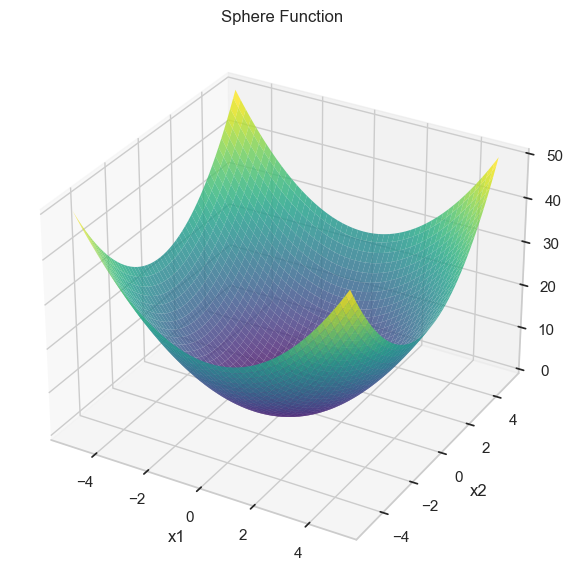

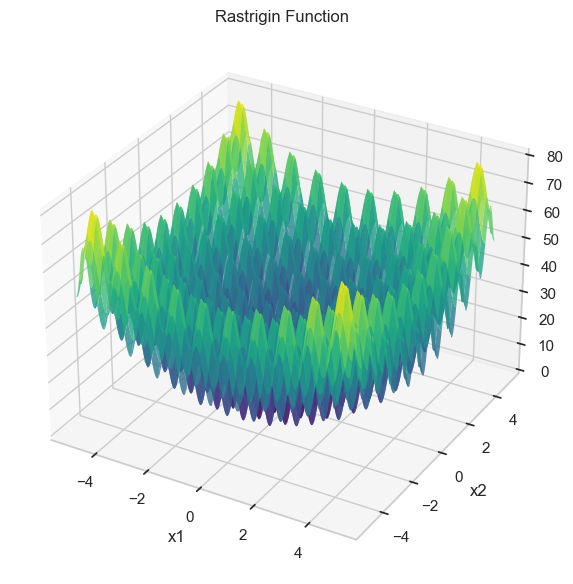

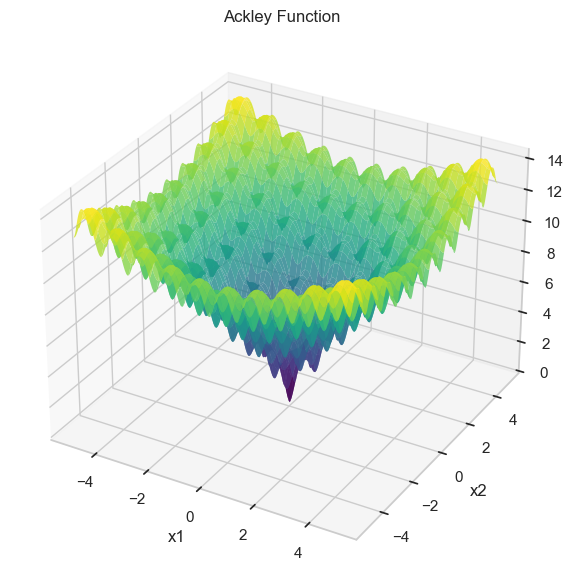

In [6]:
# %% [markdown]
# # 4) Bài toán Continuous Optimization
# Các hàm benchmark phổ biến:
# - Sphere (đơn giản, convex)
# - Rastrigin (nhiều cực trị cục bộ)
# - Ackley (mặt phức tạp, multi-modal)
# Dùng để so sánh khả năng hội tụ và chống kẹt local của thuật toán.

# %%
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# --- 4.1 Sphere function ---
def sphere(x):
    return np.sum(x**2)

# --- 4.2 Rastrigin function ---
def rastrigin(x):
    A = 10
    return A * len(x) + np.sum(x**2 - A * np.cos(2 * np.pi * x))

# --- 4.3 Ackley function ---
def ackley(x):
    a, b, c = 20, 0.2, 2 * np.pi
    n = len(x)
    s1 = np.sum(x**2)
    s2 = np.sum(np.cos(c * x))
    return -a * np.exp(-b * np.sqrt(s1/n)) - np.exp(s2/n) + a + np.e

# --- 4.4 Hàm vẽ bề mặt 3D ---
def plot_surface(func, bounds=(-5, 5), title=""):
    X = np.linspace(bounds[0], bounds[1], 200)
    Y = np.linspace(bounds[0], bounds[1], 200)
    X, Y = np.meshgrid(X, Y)
    Z = np.zeros_like(X)
    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            Z[i, j] = func(np.array([X[i, j], Y[i, j]]))
    fig = plt.figure(figsize=(8,6))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(X, Y, Z, cmap='viridis', linewidth=0, alpha=0.8)
    ax.set_title(title)
    ax.set_xlabel('x1')
    ax.set_ylabel('x2')
    plt.tight_layout()
    plt.show()

# Vẽ minh họa 3D cho trực quan
plot_surface(sphere, (-5,5), "Sphere Function")
plot_surface(rastrigin, (-5,5), "Rastrigin Function")
plot_surface(ackley, (-5,5), "Ackley Function")


In [7]:
# %% [markdown]
# # 5) Bài toán Discrete Optimization
# Đồ án yêu cầu ít nhất 1 problem rời rạc → ta dùng:
# - Knapsack 0/1 (KP): chọn vật có trọng lượng w_i và giá trị v_i, tối đa giá trị không vượt W.
# - TSP (Traveling Salesman Problem) nhỏ: tìm đường đi ngắn nhất qua N thành phố.
# Cả 2 đều có fitness dạng MINIMIZE.

# %%
# --- 5.1 Knapsack Problem ---
def make_knapsack(n_items=50, seed=42):
    rng = np.random.default_rng(seed)
    values = rng.integers(10, 100, size=n_items)
    weights = rng.integers(5, 30, size=n_items)
    capacity = int(0.4 * np.sum(weights))
    return values, weights, capacity

values, weights, CAP = make_knapsack()

def knapsack_fitness(x_bin):
    """Trả về -value nếu hợp lệ, else penalty."""
    total_w = np.sum(weights * x_bin)
    total_v = np.sum(values * x_bin)
    if total_w <= CAP:
        return -float(total_v)
    else:
        # penalty theo độ vi phạm
        return -float(total_v) + 10*(total_w - CAP)

def knapsack_repair(x_bin):
    """Sửa nghiệm nếu vượt quá sức chứa: bỏ dần item có ratio thấp."""
    total_w = np.sum(weights * x_bin)
    if total_w <= CAP:
        return x_bin
    ratio = values / weights
    idx = np.argsort(ratio)  # tăng dần
    for i in idx:
        if total_w <= CAP:
            break
        if x_bin[i] == 1:
            x_bin[i] = 0
            total_w -= weights[i]
    return x_bin


# --- 5.2 TSP nhỏ (10 thành phố) ---
def make_tsp(n_cities=10, seed=42):
    rng = np.random.default_rng(seed)
    coords = rng.random((n_cities, 2)) * 100
    dist = np.sqrt(((coords[:,None,:] - coords[None,:,:])**2).sum(axis=2))
    return coords, dist

coords, dist = make_tsp()

def tsp_length(path):
    """Tính tổng độ dài chu trình (path + quay về đầu)."""
    d = 0
    for i in range(len(path)-1):
        d += dist[path[i], path[i+1]]
    d += dist[path[-1], path[0]]
    return d



=== Sphere ===
⏱ optimize chạy 0.021s
⏱ optimize chạy 0.026s
⏱ optimize chạy 1.771s


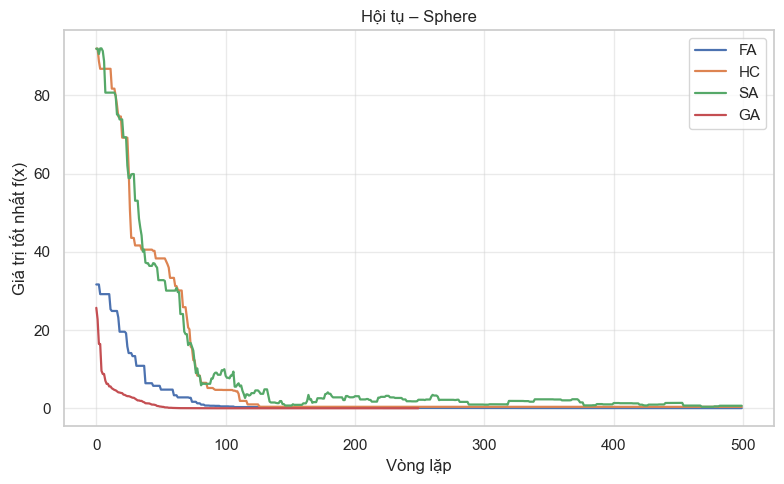

Best f(Sphere): FA=0.033661, HC=0.363159, SA=0.640687, GA=0.000023

=== Rastrigin ===
⏱ optimize chạy 0.074s
⏱ optimize chạy 0.093s
⏱ optimize chạy 4.954s


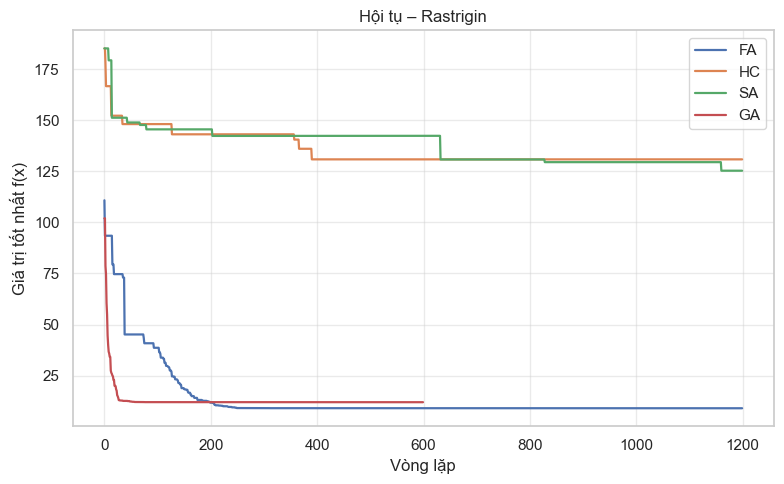

Best f(Rastrigin): FA=8.972475, HC=130.900754, SA=125.345260, GA=11.940108

=== Ackley ===
⏱ optimize chạy 0.095s
⏱ optimize chạy 0.127s
⏱ optimize chạy 5.054s


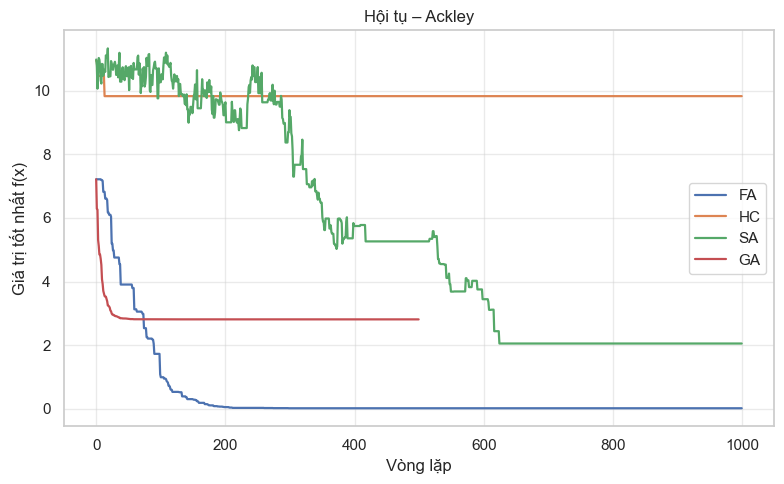

Best f(Ackley): FA=0.022391, HC=9.826894, SA=2.056176, GA=2.814357


In [8]:
# %% [markdown]
# # 6) Thử nghiệm và so sánh – Continuous Problems
# So sánh 4 thuật toán (FA, HC, SA, GA) trên 3 hàm liên tục:
# Sphere, Rastrigin, Ackley.
# FA v3 tự điều chỉnh decay, reinit và global pull nội bộ — không cần truyền thủ công.

# %%
benchmarks = [
    ("Sphere",    sphere,    (-5.12,5.12), dict(n=36,  iters=500, alpha=0.20, beta0=1.5, gamma=0.40, decay=0.985)),
    ("Rastrigin", rastrigin, (-5.12,5.12), dict(n=60,  iters=1200,alpha=0.18, beta0=0.9, gamma=0.25, decay=0.99)),
    ("Ackley",    ackley,    (-5,5),       dict(n=50,  iters=1000,alpha=0.15, beta0=0.9, gamma=0.30, decay=0.99))
]

for name, func, (lb,ub), hp in benchmarks:
    print(f"\n=== {name} ===")
    
    # Firefly v3
    fa = Firefly(func=func, dim=10, mode='continuous', lb=lb, ub=ub, seed=42,
                 k_neighbors=10, gb=0.15, **hp)
    bx_fa, bf_fa = fa.optimize()

    # Các thuật toán cổ điển
    hc = HillClimb(func=func, dim=10, mode='continuous', iters=hp['iters'], lb=lb, ub=ub, seed=42)
    _, bf_hc = hc.optimize()

    sa = SimulatedAnnealing(func=func, dim=10, mode='continuous', iters=hp['iters'], lb=lb, ub=ub, seed=42)
    _, bf_sa = sa.optimize()

    ga = GeneticAlgorithm(func=func, dim=10, mode='continuous', pop=60, iters=hp['iters']//2, lb=lb, ub=ub, seed=42)
    _, bf_ga = ga.optimize()

    plot_convergence([fa.history, hc.history, sa.history, ga.history],
                     ["FA","HC","SA","GA"], f"Hội tụ – {name}")
    print(f"Best f({name}): FA={bf_fa:.6f}, HC={bf_hc:.6f}, SA={bf_sa:.6f}, GA={bf_ga:.6f}")


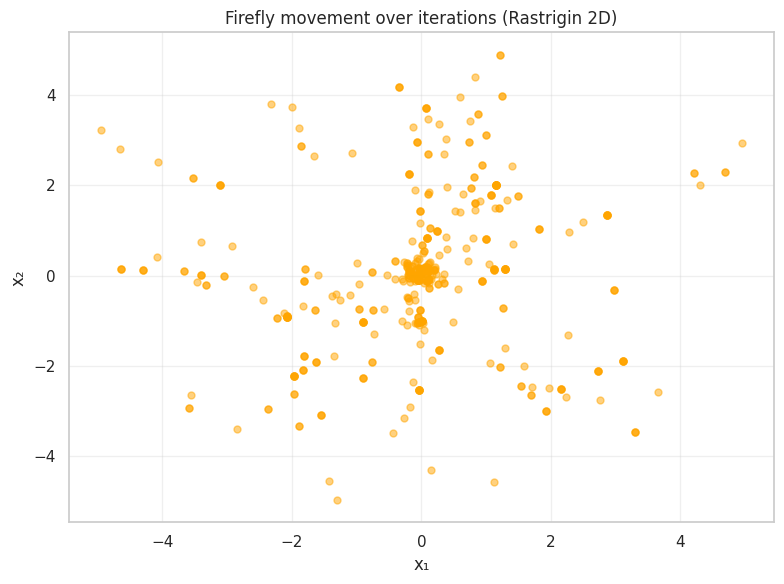

In [9]:
# %% [markdown]
# # 7) Visualizer – Quỹ đạo hội tụ Firefly (2D)
# Minh họa chuyển động đom đóm trên mặt Rastrigin (2D) (FA v3)

# %%
def visualize_fa_2d(func, bounds=(-5,5), n=25, iters=100, seed=7):
    # Firefly continuous 2D
    fa = Firefly(func=func, dim=2, mode='continuous',
                 n=n, iters=iters, alpha=0.25, beta0=1.6, gamma=0.3, decay=0.99,
                 lb=bounds[0], ub=bounds[1], seed=seed,
                 gb=0.10, k_neighbors=10)

    X, F = fa._init_population()

    plt.rcParams["font.family"] = "DejaVu Sans"
    plt.figure(figsize=(8,6))
    for t in range(iters):
        best_idx = np.argmin(F)
        best = X[best_idx].copy()
        pairs = fa.rng.integers(0, fa.n, (int(fa.n*0.3), 2))
        for i, j in pairs:
            if F[j] < F[i]:
                X[i] = fa._move_pair(X[i], X[j], best)
                if fa.rng.random() < 0.1:
                    X[i] += levy_step(fa.rng, 2, beta=1.5, scale=0.02*(fa.ub-fa.lb))
                X[i] = np.clip(X[i], fa.lb, fa.ub)
                F[i] = func(X[i])
        if t % 5 == 0:
            plt.scatter(X[:,0], X[:,1], c='orange', s=25, alpha=0.5)
    plt.title("Firefly movement over iterations (Rastrigin 2D)")
    plt.xlabel("x₁"); plt.ylabel("x₂")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# Gọi chạy
visualize_fa_2d(rastrigin)



=== Knapsack 0/1 ===
⏱ optimize chạy 0.061s
⏱ optimize chạy 0.064s
⏱ optimize chạy 3.289s


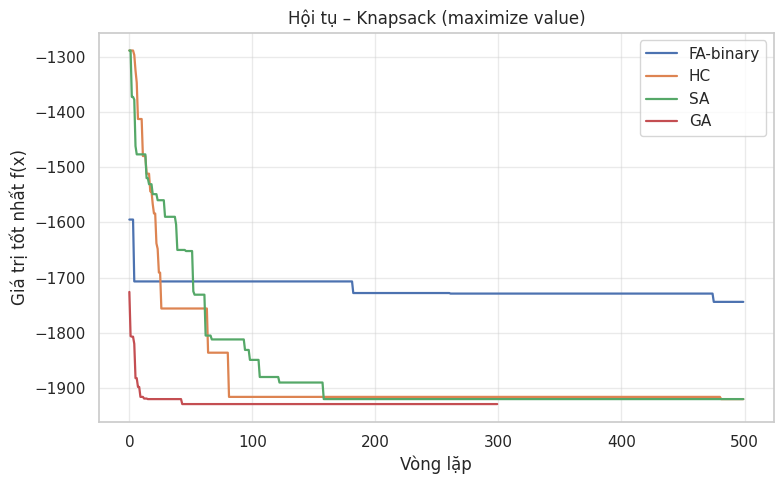

Best fitness (minimize): FA=-1744.0, HC=-1920.0, SA=-1920.0, GA=-1929.0
Best total value (FA): 1744.0
Capacity=346, Weight(FA)=345


In [10]:
# %% [markdown]
# # 8) Thử nghiệm và so sánh – Discrete (Knapsack 0/1)
# So sánh FA (binary) với Hill Climbing, Simulated Annealing, Genetic Algorithm.

print("\n=== Knapsack 0/1 ===")
fa = Firefly(func=knapsack_fitness, dim=len(values), mode='binary', seed=42,
             n=60, iters=500, alpha=0.30, beta0=0.7, gamma=0.60, decay=0.985,
             k_neighbors=10, gb=0.0, repair=knapsack_repair)
xb_fa, fb_fa = fa.optimize()

hc = HillClimb(func=knapsack_fitness, dim=len(values), mode='binary',
               iters=500, seed=42, repair=knapsack_repair)
_, fb_hc = hc.optimize()

sa = SimulatedAnnealing(func=knapsack_fitness, dim=len(values), mode='binary',
                        iters=500, seed=42, repair=knapsack_repair,
                        T0=1.5, cooling=0.995)
_, fb_sa = sa.optimize()

ga = GeneticAlgorithm(func=knapsack_fitness, dim=len(values), mode='binary',
                      pop=70, iters=300, seed=42, repair=knapsack_repair,
                      pc=0.9, pm=0.03)
_, fb_ga = ga.optimize()

plot_convergence([fa.history, hc.history, sa.history, ga.history],
                 ["FA-binary","HC","SA","GA"], "Hội tụ – Knapsack (maximize value)")

print(f"Best fitness (minimize): FA={fb_fa:.1f}, HC={fb_hc:.1f}, SA={fb_sa:.1f}, GA={fb_ga:.1f}")
print(f"Best total value (FA): {-fb_fa:.1f}")
print(f"Capacity={CAP}, Weight(FA)={int(np.sum(weights*xb_fa))}")


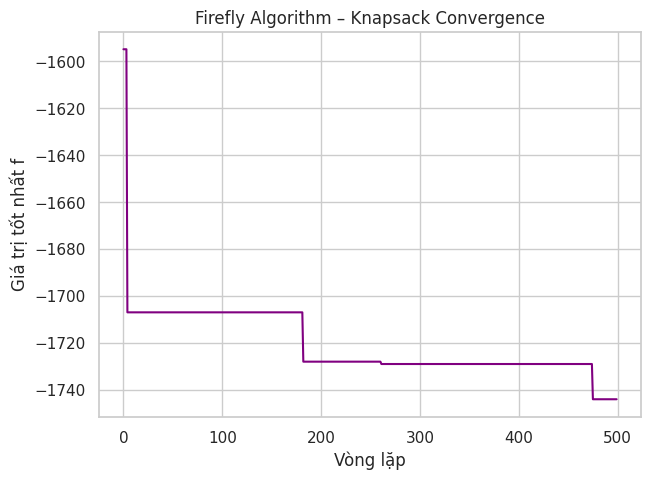

In [11]:
# %% [markdown]
# # 9) Visualizer – Phân phối giá trị fitness trong quá trình tối ưu (Discrete)
# Dùng để quan sát độ ổn định và sự đa dạng quần thể của FA hoặc GA

# %%
def plot_hist_evolution(hist, title="Phân phối fitness"):
    plt.figure(figsize=(7,5))
    plt.plot(hist, c='purple', lw=1.5)
    plt.title(title)
    plt.xlabel("Vòng lặp")
    plt.ylabel("Giá trị tốt nhất f")
    plt.grid(True)
    plt.show()

plot_hist_evolution(fa.history, "Firefly Algorithm – Knapsack Convergence")


In [12]:
# %% [markdown]
# # 10) Phân tích độ nhạy tham số – Firefly Algorithm
# Kiểm tra ảnh hưởng của alpha, beta0, gamma tới hiệu năng hội tụ.

# %% [markdown]
# # 10) Phân tích độ nhạy tham số – FA (Sphere, dim=10)
# Grid nhỏ: alpha × beta0 × gamma. Dùng seed cố định để so sánh công bằng.

# %%
alphas = [0.10, 0.20, 0.30]
betas  = [0.5, 1.0, 1.5]
gammas = [0.30, 0.40, 0.60]

results = []
for a in alphas:
    for b in betas:
        for g in gammas:
            fa = Firefly(func=sphere, dim=10, mode='continuous', lb=-5.12, ub=5.12,
             n=36, iters=400, alpha=a, beta0=b, gamma=g, decay=0.985,
             alpha_min=1e-3, seed=123, k_neighbors=10, gb=0.15)

            _, fbest = fa.optimize()
            results.append((a,b,g,fbest))
            print(f"  (alpha={a}, beta0={b}, gamma={g}) -> {fbest:.4f}")

# Hiển thị dạng bảng nếu có pandas
try:
    import pandas as pd
    df = pd.DataFrame(results, columns=["alpha","beta0","gamma","best_f"])
    display(df.pivot_table(values="best_f", index="alpha", columns="beta0"))
except Exception:
    print(results)



  (alpha=0.1, beta0=0.5, gamma=0.3) -> 0.0081
  (alpha=0.1, beta0=0.5, gamma=0.4) -> 0.0195
  (alpha=0.1, beta0=0.5, gamma=0.6) -> 0.0743
  (alpha=0.1, beta0=1.0, gamma=0.3) -> 0.0379
  (alpha=0.1, beta0=1.0, gamma=0.4) -> 0.0167
  (alpha=0.1, beta0=1.0, gamma=0.6) -> 0.0236
  (alpha=0.1, beta0=1.5, gamma=0.3) -> 0.0444
  (alpha=0.1, beta0=1.5, gamma=0.4) -> 0.0483
  (alpha=0.1, beta0=1.5, gamma=0.6) -> 0.0227
  (alpha=0.2, beta0=0.5, gamma=0.3) -> 0.0355
  (alpha=0.2, beta0=0.5, gamma=0.4) -> 0.0291
  (alpha=0.2, beta0=0.5, gamma=0.6) -> 0.0730
  (alpha=0.2, beta0=1.0, gamma=0.3) -> 0.0051
  (alpha=0.2, beta0=1.0, gamma=0.4) -> 0.0312
  (alpha=0.2, beta0=1.0, gamma=0.6) -> 0.0118
  (alpha=0.2, beta0=1.5, gamma=0.3) -> 0.0368
  (alpha=0.2, beta0=1.5, gamma=0.4) -> 0.0328
  (alpha=0.2, beta0=1.5, gamma=0.6) -> 0.0119
  (alpha=0.3, beta0=0.5, gamma=0.3) -> 0.0162
  (alpha=0.3, beta0=0.5, gamma=0.4) -> 0.0124
  (alpha=0.3, beta0=0.5, gamma=0.6) -> 0.0421
  (alpha=0.3, beta0=1.0, gamma=0.3

beta0,0.5,1.0,1.5
alpha,,,
0.1,0.033962,0.026109,0.038461
0.2,0.045835,0.016037,0.027190
0.3,0.023538,0.023147,0.041492


In [13]:
# %% [markdown]
# # Export All Figures (Firefly Algorithm – Reproducible & Complete)
# Lưu toàn bộ hình ảnh/đồ thị đúng như đã thấy trong notebook vào ./figures_FA

import os, time, math
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# ------------- Cấu hình đồ họa an toàn (tránh glyph lỗi) -------------
plt.rcParams.update({
    "font.family": "DejaVu Sans",
    "figure.dpi": 100,
    "savefig.dpi": 300
})

os.makedirs("figures_FA", exist_ok=True)

# ----------------------- Tiện ích vẽ/saving --------------------------
def _surface_3d(func, bounds=(-5,5), title=""):
    X = np.linspace(bounds[0], bounds[1], 200)
    Y = np.linspace(bounds[0], bounds[1], 200)
    X, Y = np.meshgrid(X, Y)
    Z = np.zeros_like(X)
    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            Z[i, j] = func(np.array([X[i, j], Y[i, j]]))
    fig = plt.figure(figsize=(8,6))
    ax = fig.add_subplot(111, projection="3d")
    surf = ax.plot_surface(X, Y, Z, cmap="viridis", linewidth=0, alpha=0.85)
    ax.set_title(title)
    ax.set_xlabel("x1"); ax.set_ylabel("x2")
    fig.colorbar(surf, shrink=0.6)
    return fig

def _save_convergence(histories, labels, title, path):
    fig = plt.figure(figsize=(9,5.5))
    for h, lbl in zip(histories, labels):
        plt.plot(h, label=lbl, lw=1.6)
    plt.xlabel("Iteration"); plt.ylabel("Best f(x)")
    plt.title(title)
    plt.grid(True, alpha=0.4); plt.legend()
    fig.tight_layout()
    fig.savefig(path, bbox_inches="tight")
    plt.close(fig)

def _ensure_callable(name_list):
    missing = [n for n in name_list if n not in globals()]
    if missing:
        raise NameError(f"Thiếu định nghĩa: {missing}. Hãy chạy các cell định nghĩa trước cell export.")

# --------------------- Kiểm tra hàm/ lớp cần có ----------------------
_ensure_callable([
    "sphere","rastrigin","ackley",
    "Firefly","HillClimb","SimulatedAnnealing","GeneticAlgorithm",
    "knapsack_fitness","knapsack_repair","values","weights","CAP"
])

# --------------------- 1) Surfaces: Sphere/Rastrigin/Ackley ----------
for func, nm in [(sphere,"sphere"),(rastrigin,"rastrigin"),(ackley,"ackley")]:
    fig = _surface_3d(func, (-5,5), f"{nm.capitalize()} Function Surface")
    fig.savefig(f"figures_FA/fa_surface_{nm}.png", bbox_inches="tight")
    plt.close(fig)

# --------------------- 2) Convergence (3 benchmark liên tục) ---------
# Nếu đã có dict FA_RUNS từ cell thí nghiệm trước thì dùng; nếu không, chạy lại nhanh với đúng seed/hyper
if "FA_RUNS" not in globals():
    FA_RUNS = {}
    benchmarks = [
        ("Sphere",    sphere,    (-5.12,5.12), dict(n=36,  iters=500,  alpha=0.20, beta0=1.5, gamma=0.40, decay=0.985)),
        ("Rastrigin", rastrigin, (-5.12,5.12), dict(n=60,  iters=1200, alpha=0.18, beta0=0.9, gamma=0.25, decay=0.99)),
        ("Ackley",    ackley,    (-5,5),       dict(n=50,  iters=1000, alpha=0.15, beta0=0.9, gamma=0.30, decay=0.99)),
    ]
    for name, func, (lb,ub), hp in benchmarks:
        fa = Firefly(func=func, dim=10, mode="continuous", lb=lb, ub=ub, seed=42, k_neighbors=10, gb=0.15, **hp)
        fa.optimize()
        hc = HillClimb(func=func, dim=10, mode="continuous", iters=hp["iters"], lb=lb, ub=ub, seed=42); hc.optimize()
        sa = SimulatedAnnealing(func=func, dim=10, mode="continuous", iters=hp["iters"], lb=lb, ub=ub, seed=42); sa.optimize()
        ga = GeneticAlgorithm(func=func, dim=10, mode="continuous", pop=60, iters=hp["iters"]//2, lb=lb, ub=ub, seed=42); ga.optimize()
        FA_RUNS[name] = {"FA": fa.history[:], "HC": hc.history[:], "SA": sa.history[:], "GA": ga.history[:]}

# Xuất từng đồ thị hội tụ theo đúng benchmark
for name in ["Sphere","Rastrigin","Ackley"]:
    H = FA_RUNS[name]
    _save_convergence([H["FA"], H["HC"], H["SA"], H["GA"]],
                      ["FA","HC","SA","GA"],
                      f"Convergence – {name}",
                      f"figures_FA/fa_convergence_{name.lower()}.png")

# --------------------- 3) Trajectory Rastrigin 2D --------------------
# Bổ sung bản không show để tránh trắng hình
def visualize_fa_2d_save(func, bounds=(-5,5), n=25, iters=150, seed=123, path="figures_FA/fa_trajectory_rastrigin.png"):
    fa = Firefly(func=func, dim=2, mode="continuous",
                 n=n, iters=iters, alpha=0.25, beta0=1.6, gamma=0.3, decay=0.99,
                 lb=bounds[0], ub=bounds[1], seed=seed, gb=0.10, k_neighbors=10)
    X, F = fa._init_population()
    fig = plt.figure(figsize=(8,6))
    for t in range(iters):
        best_idx = np.argmin(F); best = X[best_idx].copy()
        pairs = fa.rng.integers(0, fa.n, (int(fa.n*0.3), 2))
        for i, j in pairs:
            if F[j] < F[i]:
                X[i] = fa._move_pair(X[i], X[j], best)
                if fa.rng.random() < 0.1:
                    X[i] += levy_step(fa.rng, 2, beta=1.5, scale=0.02*(fa.ub-fa.lb))
                X[i] = np.clip(X[i], fa.lb, fa.ub)
                F[i] = func(X[i])
        if t % 5 == 0:
            plt.scatter(X[:,0], X[:,1], c="#f5a623", s=26, alpha=0.55)
    plt.title("Firefly movement over iterations (Rastrigin 2D)")
    plt.xlabel("x1"); plt.ylabel("x2")
    plt.grid(True, alpha=0.35); fig.tight_layout()
    fig.savefig(path, bbox_inches="tight"); plt.close(fig)

visualize_fa_2d_save(rastrigin)

# --------------------- 4) Heatmap độ nhạy tham số (alpha,beta0,gamma) --------
# Nếu biến 'results' (alpha,beta0,gamma,best_f) đã có sẵn, dùng trực tiếp; nếu không, chạy lại lưới giống cell 10.
if "results" not in globals():
    alphas = [0.10, 0.20, 0.30]
    betas  = [0.5, 1.0, 1.5]
    gammas = [0.30, 0.40, 0.60]
    results = []
    for a in alphas:
        for b in betas:
            for g in gammas:
                fa_tmp = Firefly(func=sphere, dim=10, mode="continuous", lb=-5.12, ub=5.12,
                                 n=36, iters=400, alpha=a, beta0=b, gamma=g, decay=0.985,
                                 alpha_min=1e-3, seed=123, k_neighbors=10, gb=0.15)
                _, fbest = fa_tmp.optimize()
                results.append((a,b,g,fbest))

df = pd.DataFrame(results, columns=["alpha","beta0","gamma","best_f"])
pivot = df.pivot_table(values="best_f", index="alpha", columns="beta0")
fig = plt.figure(figsize=(6.4,4.2))
import seaborn as sns
sns.heatmap(pivot, annot=True, cmap="viridis", fmt=".4f")
plt.title("Parameter Sensitivity – Sphere Function (FA)")
plt.xlabel("beta0"); plt.ylabel("alpha")
fig.tight_layout()
fig.savefig("figures_FA/fa_sensitivity_sphere.png", bbox_inches="tight")
plt.close(fig)

# --------------------- 5) Runtime vs Dimension -----------------------
dims = [2, 10, 30, 60]
times = []
for d in dims:
    fa_tmp = Firefly(sphere, dim=d, mode="continuous",
                     lb=-5.12, ub=5.12, n=30, iters=300,
                     alpha=0.5, beta0=1.0, gamma=1.0, seed=42)
    t0 = time.time(); fa_tmp.optimize(); times.append(time.time()-t0)

fig = plt.figure(figsize=(6.0,3.8))
plt.plot(dims, times, marker="o")
plt.title("FA Runtime vs Dimension – Sphere")
plt.xlabel("Dimension"); plt.ylabel("Time (s)")
plt.grid(True, alpha=0.4)
fig.tight_layout()
fig.savefig("figures_FA/fa_runtime_vs_dim.png", bbox_inches="tight")
plt.close(fig)

# --------------------- 6) Knapsack: hội tụ & lịch sử -----------------
# Chạy lại đúng cấu hình trong notebook, seed 42
fa_kn = Firefly(func=knapsack_fitness, dim=len(values), mode="binary", seed=42,
                n=60, iters=500, alpha=0.30, beta0=0.7, gamma=0.60, decay=0.985,
                k_neighbors=10, gb=0.0, repair=knapsack_repair)
fa_kn.optimize()

hc_kn = HillClimb(func=knapsack_fitness, dim=len(values), mode="binary", iters=500, seed=42, repair=knapsack_repair); hc_kn.optimize()
sa_kn = SimulatedAnnealing(func=knapsack_fitness, dim=len(values), mode="binary", iters=500, seed=42, repair=knapsack_repair, T0=1.5, cooling=0.995); sa_kn.optimize()
ga_kn = GeneticAlgorithm(func=knapsack_fitness, dim=len(values), mode="binary", pop=70, iters=300, seed=42, repair=knapsack_repair, pc=0.9, pm=0.03); ga_kn.optimize()

_save_convergence([fa_kn.history, hc_kn.history, sa_kn.history, ga_kn.history],
                  ["FA-binary","HC","SA","GA"],
                  "Convergence – Knapsack (maximize value)",
                  "figures_FA/fa_convergence_knapsack.png")

fig = plt.figure(figsize=(8,4.6))
plt.plot(fa_kn.history, c="purple", lw=1.6)
plt.title("Firefly Algorithm – Knapsack Convergence")
plt.xlabel("Iteration"); plt.ylabel("Best f")
plt.grid(True, alpha=0.35); fig.tight_layout()
fig.savefig("figures_FA/fa_hist_knapsack.png", bbox_inches="tight")
plt.close(fig)

print("All FA figures are saved under ./figures_FA/:")
print(" - fa_surface_{sphere|rastrigin|ackley}.png")
print(" - fa_convergence_{sphere|rastrigin|ackley}.png")
print(" - fa_trajectory_rastrigin.png")
print(" - fa_sensitivity_sphere.png")
print(" - fa_runtime_vs_dim.png")
print(" - fa_convergence_knapsack.png, fa_hist_knapsack.png")


⏱ optimize chạy 0.022s
⏱ optimize chạy 0.013s
⏱ optimize chạy 1.772s
⏱ optimize chạy 0.070s
⏱ optimize chạy 0.037s
⏱ optimize chạy 4.840s
⏱ optimize chạy 0.089s
⏱ optimize chạy 0.105s
⏱ optimize chạy 5.040s
⏱ optimize chạy 0.092s
⏱ optimize chạy 0.034s
⏱ optimize chạy 4.074s
All FA figures are saved under ./figures_FA/:
 - fa_surface_{sphere|rastrigin|ackley}.png
 - fa_convergence_{sphere|rastrigin|ackley}.png
 - fa_trajectory_rastrigin.png
 - fa_sensitivity_sphere.png
 - fa_runtime_vs_dim.png
 - fa_convergence_knapsack.png, fa_hist_knapsack.png
